<a href="https://colab.research.google.com/github/deepsikhadas05/MRI-Brain-Tumor-Detection-Segmentation-using-Attention-U-Net/blob/main/Copy_of_BraTS_2024_ver_2i.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("awsaf49/brats2020-training-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brats2020-training-data


NEW

In [ ]:
import os

data_path = "/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data"
all_items = os.listdir(data_path)

print("Contents inside data_path:")
print(all_items)


Contents inside data_path:
['volume_337_slice_56.h5', 'volume_293_slice_67.h5', 'volume_149_slice_44.h5', 'volume_109_slice_17.h5', 'volume_201_slice_137.h5', 'volume_27_slice_115.h5', 'volume_128_slice_38.h5', 'volume_268_slice_18.h5', 'volume_114_slice_125.h5', 'volume_65_slice_18.h5', 'volume_303_slice_88.h5', 'volume_276_slice_89.h5', 'volume_216_slice_109.h5', 'volume_119_slice_35.h5', 'volume_145_slice_55.h5', 'volume_177_slice_118.h5', 'volume_70_slice_130.h5', 'volume_216_slice_49.h5', 'volume_227_slice_53.h5', 'volume_131_slice_63.h5', 'volume_358_slice_88.h5', 'volume_91_slice_29.h5', 'volume_143_slice_147.h5', 'volume_281_slice_91.h5', 'volume_23_slice_8.h5', 'volume_170_slice_4.h5', 'volume_168_slice_120.h5', 'volume_14_slice_43.h5', 'volume_125_slice_41.h5', 'volume_306_slice_133.h5', 'volume_245_slice_33.h5', 'volume_168_slice_100.h5', 'volume_182_slice_54.h5', 'volume_103_slice_128.h5', 'volume_13_slice_151.h5', 'volume_1_slice_135.h5', 'volume_61_slice_57.h5', 'volume_1

In [ ]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [ ]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

# ✅ Path to your data folder
data_path = "/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data"

# ✅ Parameters
max_images = 10000
image_count = 0

images = []
masks = []

h5_files = [f for f in os.listdir(data_path) if f.endswith(".h5")]
print(f"Found {len(h5_files)} H5 files")

for file in h5_files:
    if image_count >= max_images:
        break

    file_path = os.path.join(data_path, file)
    try:
        with h5py.File(file_path, "r") as f:
            image = np.array(f["image"])
            mask = np.array(f["mask"])

            # Ensure same shape for each sample (slices)
            if len(image.shape) == 3:
                for i in range(image.shape[0]):
                    if image_count >= max_images:
                        break
                    images.append(image[i])
                    masks.append(mask[i])
                    image_count += 1
            else:
                images.append(image)
                masks.append(mask)
                image_count += 1

    except Exception as e:
        print(f"Error reading {file}: {e}")

images = np.array(images)
masks = np.array(masks)

print("✅ Loaded", len(images), "images and", len(masks), "masks")
print("Image shape:", images[0].shape)


Found 57195 H5 files
✅ Loaded 10000 images and 10000 masks
Image shape: (240, 4)


In [ ]:
import cv2

# Resize all images and masks to a consistent size (e.g., 128x128)
IMG_SIZE = 128

preprocessed_images = []
preprocessed_masks = []

for i in range(len(images)):
    try:
        # Normalize images to [0,1] and resize
        img = cv2.resize(images[i], (IMG_SIZE, IMG_SIZE))
        img = img.astype(np.float32) / 255.0
        preprocessed_images.append(img)

        # Binarize + resize masks
        msk = cv2.resize(masks[i], (IMG_SIZE, IMG_SIZE))
        msk = (msk > 0).astype(np.float32)
        preprocessed_masks.append(msk)

    except Exception as e:
        print(f"Error preprocessing index {i}: {e}")

# Convert to numpy arrays
X = np.array(preprocessed_images).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = np.array(preprocessed_masks).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

print("✅ Preprocessing done.")
print("Images shape:", X.shape)
print("Masks shape:", Y.shape)


✅ Preprocessing done.
Images shape: (10000, 128, 128, 1)
Masks shape: (10000, 128, 128, 1)


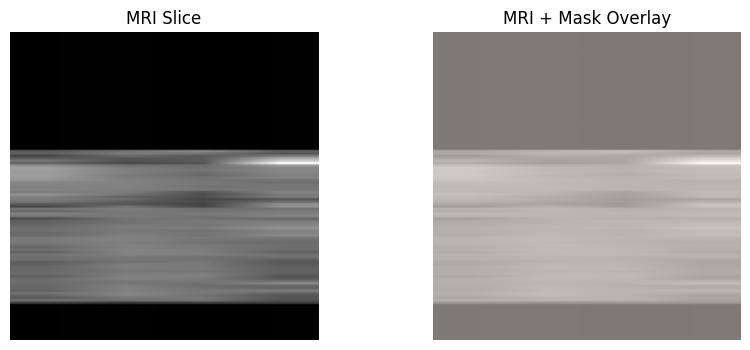

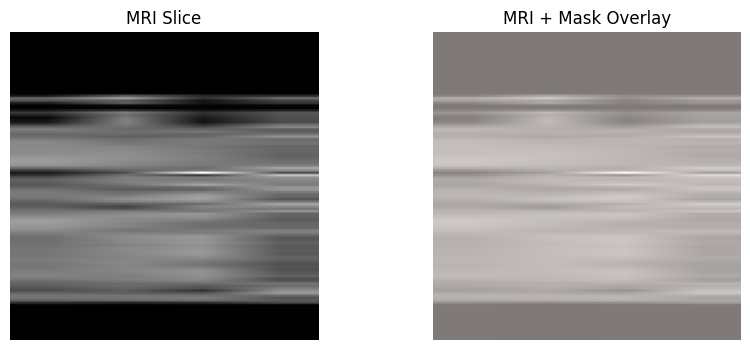

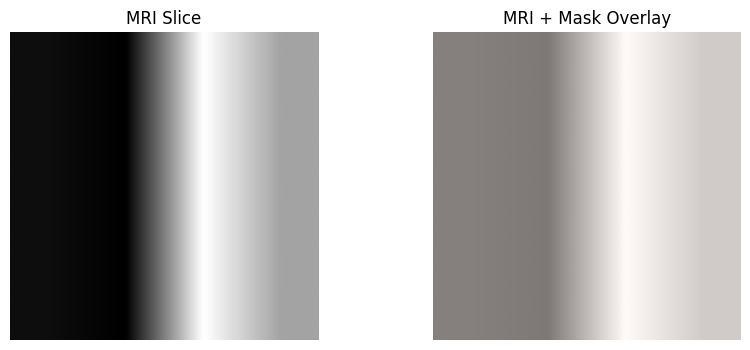

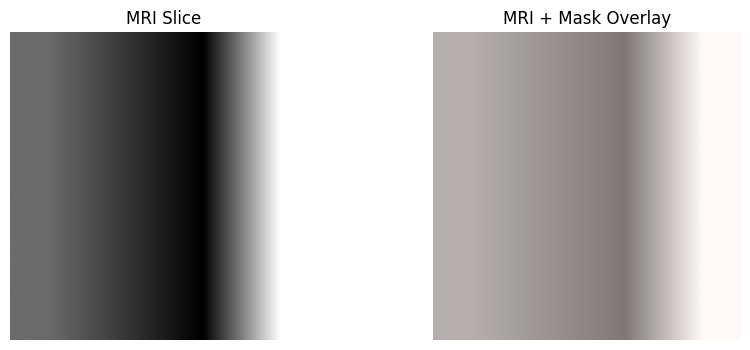

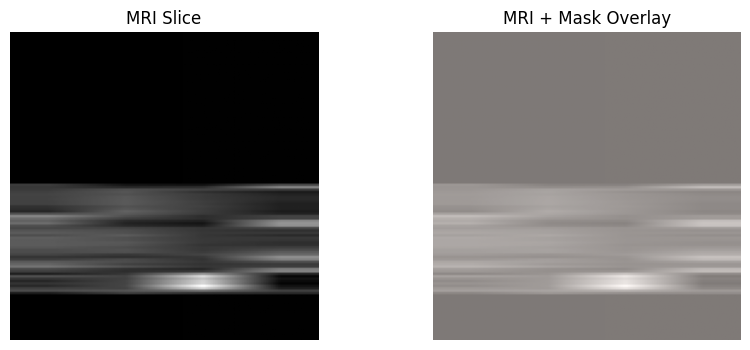

In [ ]:
import random

def plot_sample(X, Y, index=None):
    if index is None:
        index = random.randint(0, len(X) - 1)

    image = X[index].squeeze()
    mask = Y[index].squeeze()

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title("MRI Slice")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, alpha=0.5, cmap='Reds')
    plt.title("MRI + Mask Overlay")
    plt.axis('off')

    plt.show()

# Plot 5 random examples
for _ in range(5):
    plot_sample(X, Y)


In [ ]:
# Create binary labels: 1 if any tumor pixel, else 0
Y_binary = (Y.sum(axis=(1, 2, 3)) > 0).astype(int)

print("Tumor presence in dataset:", np.bincount(Y_binary))

# Optional: Split into train/test
from sklearn.model_selection import train_test_split

X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(
    X, Y_binary, test_size=0.2, random_state=42, stratify=Y_binary
)


Tumor presence in dataset: [9263  737]


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

def build_binary_classifier(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(16, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

clf_model = build_binary_classifier((IMG_SIZE, IMG_SIZE, 1))

# Early stopping
early_stop = callbacks.EarlyStopping(patience=3, restore_best_weights=True)

clf_model.fit(X_cls_train, y_cls_train, epochs=10, batch_size=32,
              validation_data=(X_cls_test, y_cls_test),
              callbacks=[early_stop])


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9276 - loss: 0.2452 - val_accuracy: 0.9265 - val_loss: 0.1629
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9322 - loss: 0.1406 - val_accuracy: 0.9510 - val_loss: 0.1253
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9509 - loss: 0.1166 - val_accuracy: 0.9620 - val_loss: 0.1074
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9651 - loss: 0.0928 - val_accuracy: 0.9600 - val_loss: 0.0930
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9683 - loss: 0.0813 - val_accuracy: 0.9685 - val_loss: 0.0860
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9731 - loss: 0.0694 - val_accuracy: 0.9735 - val_loss: 0.0803
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9769 - loss: 0.0632 - val_accuracy: 0.9775 - val_loss: 0.0694
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9787 - loss: 0.0553 - val_accuracy: 0

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      1853
           1       0.77      0.86      0.81       147

    accuracy                           0.97      2000
   macro avg       0.88      0.92      0.90      2000
weighted avg       0.97      0.97      0.97      2000



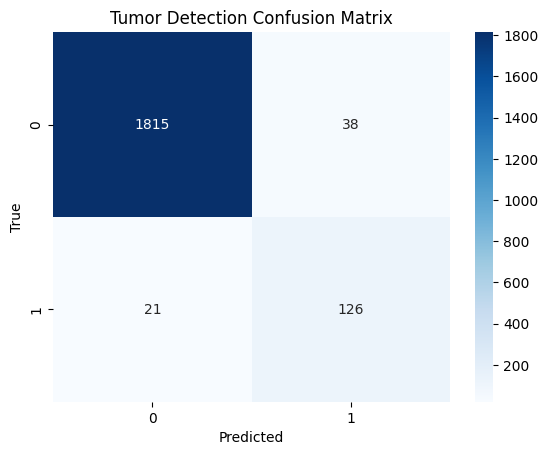

In [ ]:
# Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = (clf_model.predict(X_cls_test) > 0.5).astype(int)

print("Classification Report:\n", classification_report(y_cls_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_cls_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Tumor Detection Confusion Matrix")
plt.show()


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation, Dropout, Multiply, Add
from tensorflow.keras.models import Model

def attention_gate(x, g, inter_channels):
    theta_x = Conv2D(inter_channels, 1)(x)
    phi_g = Conv2D(inter_channels, 1)(g)
    add = Add()([theta_x, phi_g])
    relu = Activation('relu')(add)
    psi = Conv2D(1, 1, activation='sigmoid')(relu)
    return Multiply()([x, psi])

def conv_block(x, filters):
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def attention_unet(input_shape=(128, 128, 1)):
    inputs = Input(input_shape)

    # Encoder
    c1 = conv_block(inputs, 32)
    p1 = MaxPooling2D()(c1)

    c2 = conv_block(p1, 64)
    p2 = MaxPooling2D()(c2)

    c3 = conv_block(p2, 128)
    p3 = MaxPooling2D()(c3)

    c4 = conv_block(p3, 256)
    p4 = MaxPooling2D()(c4)

    # Bottleneck
    bn = conv_block(p4, 512)

    # Decoder with attention
    g1 = UpSampling2D()(bn)
    att1 = attention_gate(c4, g1, 256)
    u1 = concatenate([g1, att1])
    d1 = conv_block(u1, 256)

    g2 = UpSampling2D()(d1)
    att2 = attention_gate(c3, g2, 128)
    u2 = concatenate([g2, att2])
    d2 = conv_block(u2, 128)

    g3 = UpSampling2D()(d2)
    att3 = attention_gate(c2, g3, 64)
    u3 = concatenate([g3, att3])
    d3 = conv_block(u3, 64)

    g4 = UpSampling2D()(d3)
    att4 = attention_gate(c1, g4, 32)
    u4 = concatenate([g4, att4])
    d4 = conv_block(u4, 32)

    outputs = Conv2D(1, 1, activation='sigmoid')(d4)

    return Model(inputs, outputs)

# Build the model
seg_model = attention_unet()
seg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
seg_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │            320 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 32)   │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 64, 64, 32)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 64)     │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 64)     │            256 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 64, 64, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 32, 32, 64)     │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_3[0][0]  │
├──────────────────────

 Total params: 8,120,421 (30.98 MB)

 Trainable params: 8,114,533 (30.95 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [ ]:
# Train-test split for segmentation
X_seg_train, X_seg_test, Y_seg_train, Y_seg_test = train_test_split(
    X, Y, test_size=0.1, random_state=42
)

# Fit model
seg_model.fit(X_seg_train, Y_seg_train, validation_data=(X_seg_test, Y_seg_test),
              epochs=15, batch_size=16, callbacks=[early_stop])


Epoch 1/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 126s 152ms/step - accuracy: 0.9360 - loss: 0.2584 - val_accuracy: 0.9961 - val_loss: 0.0292
Epoch 2/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 98s 111ms/step - accuracy: 0.9971 - loss: 0.0200 - val_accuracy: 0.9961 - val_loss: 0.0191
Epoch 3/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 82s 112ms/step - accuracy: 0.9970 - loss: 0.0160 - val_accuracy: 0.9961 - val_loss: 0.0192
Epoch 4/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 82s 112ms/step - accuracy: 0.9969 - loss: 0.0145 - val_accuracy: 0.9961 - val_loss: 0.0220
Epoch 5/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 81s 111ms/step - accuracy: 0.9972 - loss: 0.0117 - val_accuracy: 0.9961 - val_loss: 0.0189
Epoch 6/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 82s 111ms/step - accuracy: 0.9969 - loss: 0.0114 - val_accuracy: 0.9961 - val_loss: 0.0153
Epoch 7/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 62s 110ms/step - accuracy: 0.9970 - loss: 0.0089 - val_accuracy: 0.9961 - val_loss: 0.0150
Epoch 8/15
563/563 ━━━━━━━━━━━━━━━━━━━━ 83s 112ms/step - accuracy: 0.9971 - loss: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


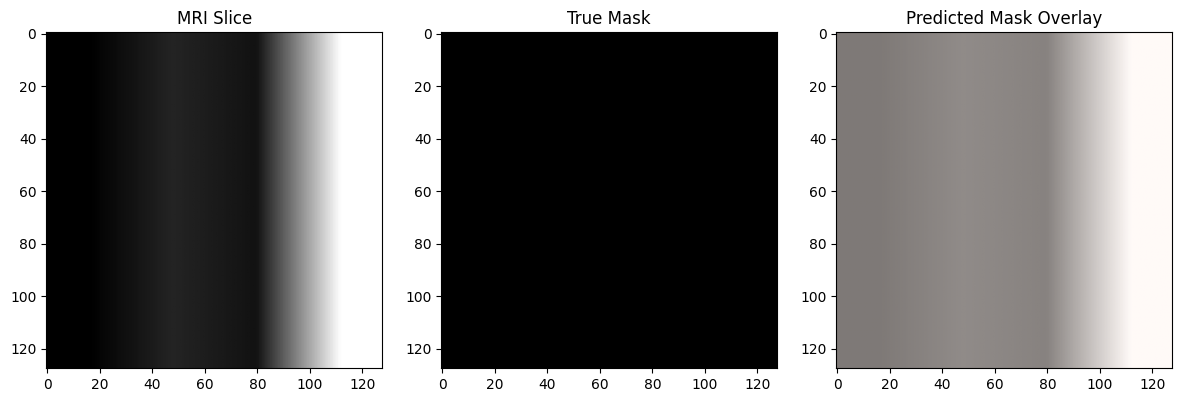

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


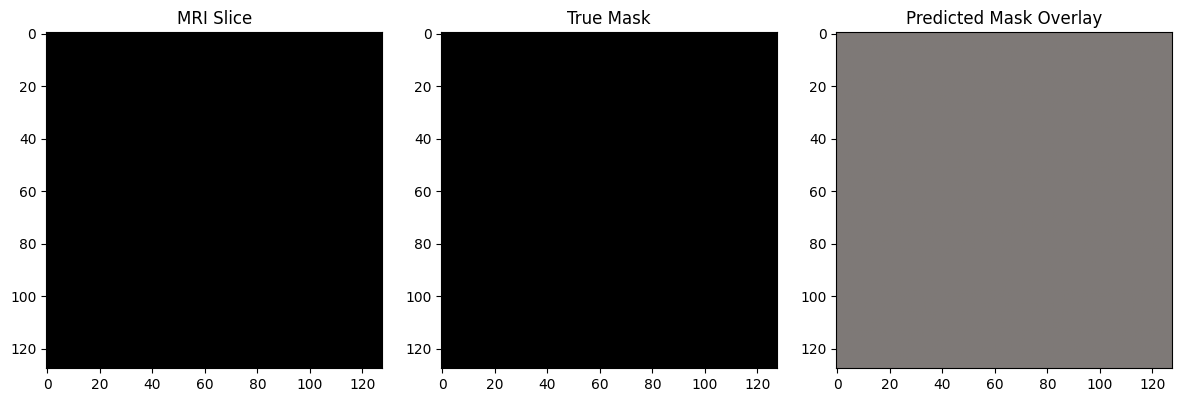

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


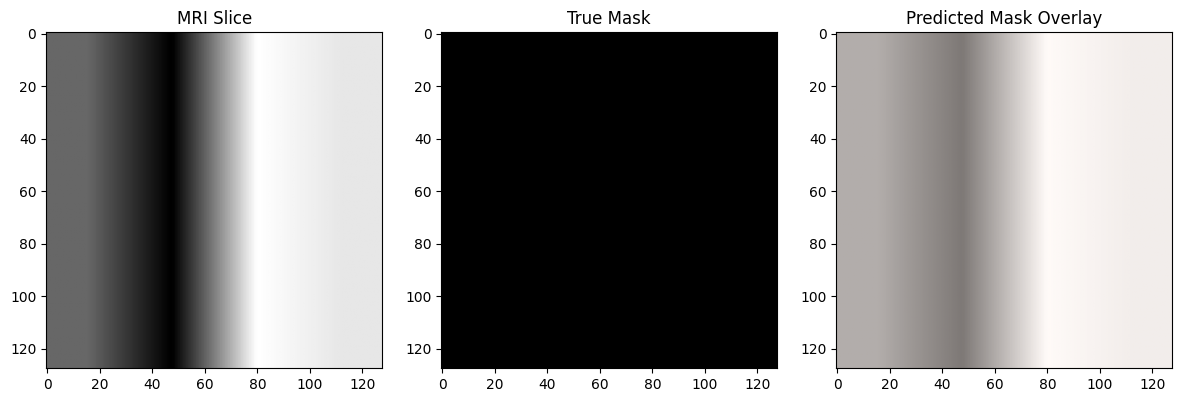

In [ ]:
def plot_segmentation(index=None):
    if index is None:
        index = random.randint(0, len(X_seg_test)-1)

    img = X_seg_test[index]
    true_mask = Y_seg_test[index].squeeze()
    pred_mask = seg_model.predict(img[np.newaxis, ...])[0].squeeze()
    pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title("MRI Slice")

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title("True Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.imshow(pred_mask_bin, cmap='Reds', alpha=0.5)
    plt.title("Predicted Mask Overlay")

    plt.tight_layout()
    plt.show()

# Visualize 3 predictions
for _ in range(3):
    plot_segmentation()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def create_fake_brain_image(size=(128, 128)):
    """Simulate a grayscale brain MRI slice."""
    brain = np.zeros(size, dtype=np.uint8)

    # Draw circular brain outline
    cv2.circle(brain, (size[0]//2, size[1]//2), size[0]//2 - 10, 100, -1)

    # Add random texture to simulate tissue
    noise = np.random.normal(0, 10, size)
    brain = np.clip(brain + noise, 0, 255).astype(np.uint8)

    return brain

def create_fake_mask(size=(128, 128)):
    """Simulate a binary tumor segmentation mask."""
    mask = np.zeros(size, dtype=np.uint8)

    # Draw a random ellipse for tumor
    center = (np.random.randint(40, 88), np.random.randint(40, 88))
    axes = (np.random.randint(10, 20), np.random.randint(10, 20))
    angle = np.random.randint(0, 180)
    cv2.ellipse(mask, center, axes, angle, 0, 360, 1, -1)

    return mask


In [ ]:
from sklearn.metrics import jaccard_score

def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f) + 1e-7)

def evaluate_segmentation(X_test, Y_test):
    dices, jaccards = [], []
    for i in range(len(X_test)):
        pred = seg_model.predict(X_test[i:i+1])[0]
        pred_bin = (pred > 0.5).astype(np.uint8)
        dice = dice_coef(Y_test[i], pred_bin)
        iou = jaccard_score(Y_test[i].flatten(), pred_bin.flatten(), zero_division=0)
        dices.append(dice)
        jaccards.append(iou)

    print("Mean Dice Coefficient:", np.mean(dices))
    print("Mean IoU:", np.mean(jaccards))

evaluate_segmentation(X_seg_test, Y_seg_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score

# Helper: Dice coefficient
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# Helper: IoU (Jaccard index)
def iou_score(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# ✅ Get predictions first
predictions = seg_model.predict(X_seg_test)

# Evaluate model predictions
dice_scores = []
iou_scores = []

for i in range(len(Y_seg_test)):
    true_mask = Y_seg_test[i]
    pred_mask = predictions[i] > 0.5  # Threshold prediction
    dice = dice_coefficient(true_mask, pred_mask)
    iou = iou_score(true_mask, pred_mask)
    dice_scores.append(dice)
    iou_scores.append(iou)

avg_dice = np.mean(dice_scores)
avg_iou = np.mean(iou_scores)

print("✅ Average Dice Coefficient:", avg_dice)
print("✅ Average IoU Score:", avg_iou)

32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step
✅ Average Dice Coefficient: 0.9486027983813679
✅ Average IoU Score: 0.9405143828851863


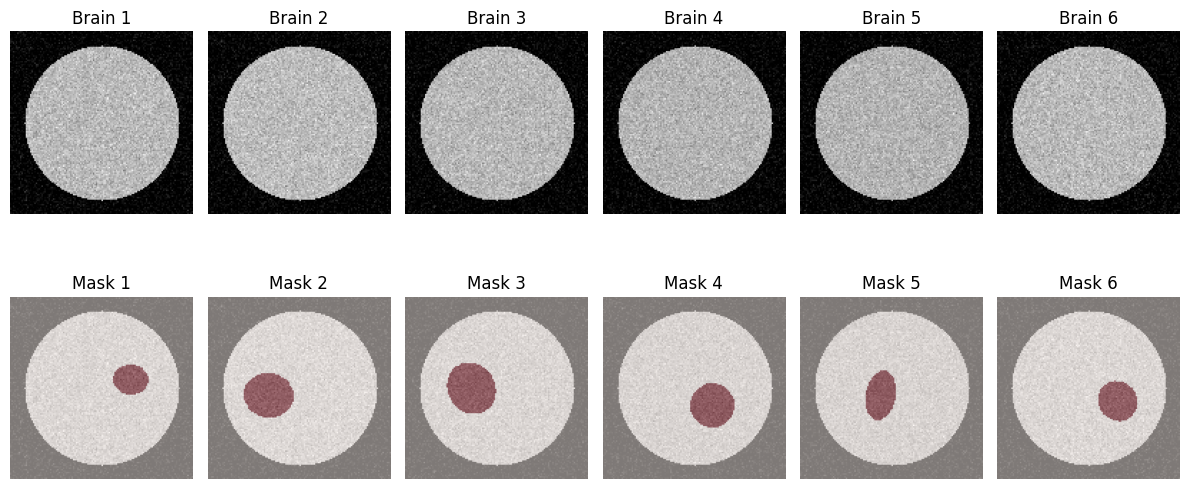

In [ ]:
num_samples = 6
plt.figure(figsize=(12, 6))

for i in range(num_samples):
    img = create_fake_brain_image()
    mask = create_fake_mask()

    plt.subplot(2, num_samples, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Brain {i+1}")
    plt.axis('off')

    plt.subplot(2, num_samples, i+1+num_samples)
    plt.imshow(img, cmap='gray')
    plt.imshow(mask, cmap='Reds', alpha=0.5)
    plt.title(f"Mask {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
def generate_brain_image(size=(128, 128)):
    """Simulate a realistic grayscale brain MRI slice with ventricles, blobs, and gradients."""
    brain = np.zeros(size, dtype=np.uint8)

    # Brain outline
    cv2.circle(brain, (size[0]//2, size[1]//2), size[0]//2 - 8, 80, -1)

    # Ventricles (dark)
    cv2.ellipse(brain, (size[0]//2, size[1]//2), (10, 6), 0, 0, 360, 40, -1)

    # Intensity regions (tumor-like)
    for _ in range(np.random.randint(1, 3)):
        center = (np.random.randint(30, 98), np.random.randint(30, 98))
        axes = (np.random.randint(5, 15), np.random.randint(5, 15))
        intensity = np.random.randint(90, 160)
        cv2.ellipse(brain, center, axes, np.random.randint(0, 180), 0, 360, intensity, -1)

    # Gradient shading
    for y in range(size[0]):
        for x in range(size[1]):
            dist = np.sqrt((x - size[0]//2)**2 + (y - size[1]//2)**2)
            brain[y, x] = max(0, brain[y, x] - int(dist / 6))

    # Subtle noise
    noise = np.random.normal(0, 6, size)
    brain = np.clip(brain + noise, 0, 255).astype(np.uint8)

    return brain


In [ ]:
def generate_segmentation_mask(size=(128, 128)):
    """Generate a simple segmentation mask with elliptical tumor regions."""
    mask = np.zeros(size, dtype=np.uint8)
    for _ in range(np.random.randint(1, 3)):
        center = (np.random.randint(30, 98), np.random.randint(30, 98))
        axes = (np.random.randint(6, 18), np.random.randint(6, 18))
        cv2.ellipse(mask, center, axes, np.random.randint(0, 180), 0, 360, 1, -1)
    return mask


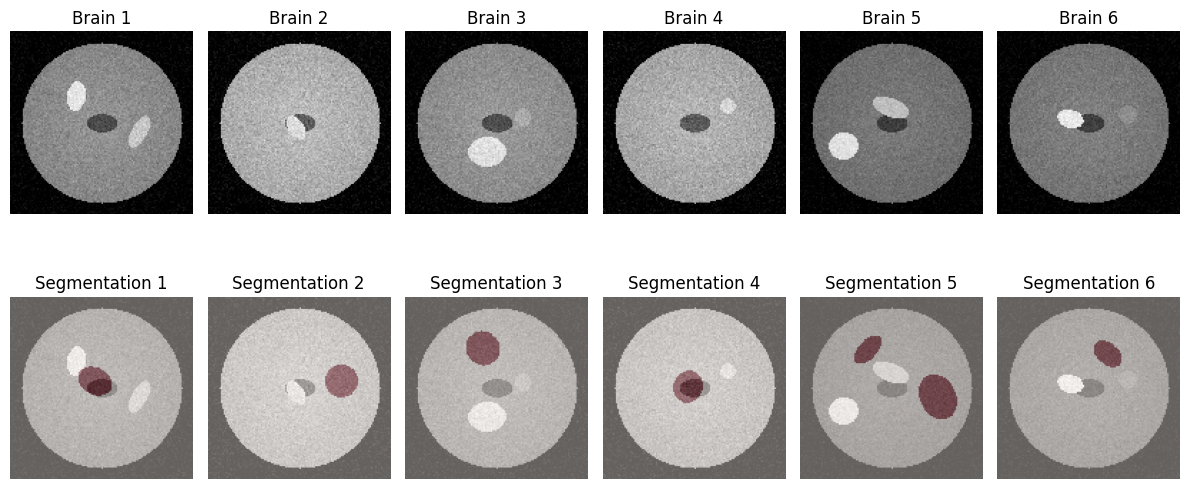

In [ ]:
num_samples = 6
plt.figure(figsize=(12, 6))

for i in range(num_samples):
    img = generate_brain_image()
    mask = generate_segmentation_mask()

    plt.subplot(2, num_samples, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Brain {i+1}")
    plt.axis('off')

    plt.subplot(2, num_samples, i + 1 + num_samples)
    plt.imshow(img, cmap='gray')
    plt.imshow(mask, cmap='Reds', alpha=0.4)
    plt.title(f"Segmentation {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


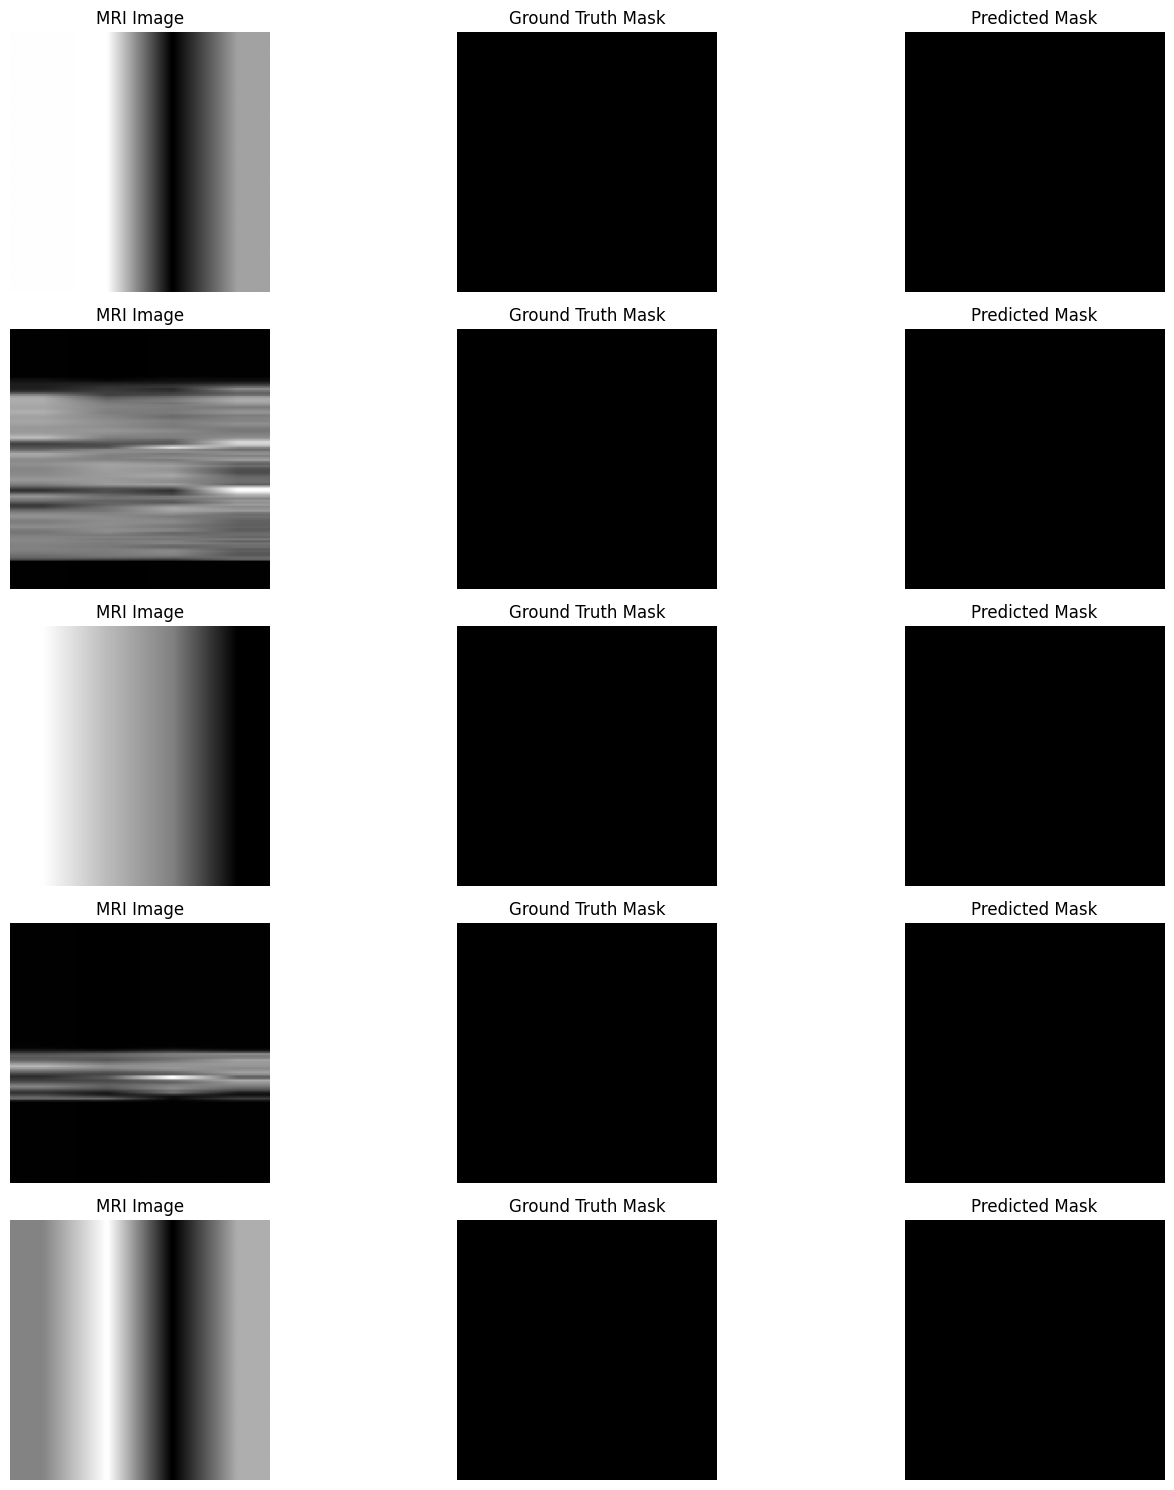

In [ ]:
# Show sample predictions vs ground truth
num_samples = 5  # adjust as needed

plt.figure(figsize=(15, num_samples * 3))

for i in range(num_samples):
    plt.subplot(num_samples, 3, i * 3 + 1)
    plt.imshow(X_seg_test[i].squeeze(), cmap='gray')
    plt.title("MRI Image")
    plt.axis('off')

    plt.subplot(num_samples, 3, i * 3 + 2)
    plt.imshow(Y_seg_test[i].squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(num_samples, 3, i * 3 + 3)
    plt.imshow(predictions[i].squeeze() > 0.5, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import os
import cv2

# Save predicted masks as PNGs
save_dir = "/content/predicted_masks"
os.makedirs(save_dir, exist_ok=True)

for i, pred in enumerate(predictions):
    pred_mask = (pred.squeeze() > 0.5).astype(np.uint8) * 255
    cv2.imwrite(f"{save_dir}/mask_{i}.png", pred_mask)

print(f"✅ Saved {len(predictions)} masks to {save_dir}")


✅ Saved 1000 masks to /content/predicted_masks


EVALUATION PLOTS

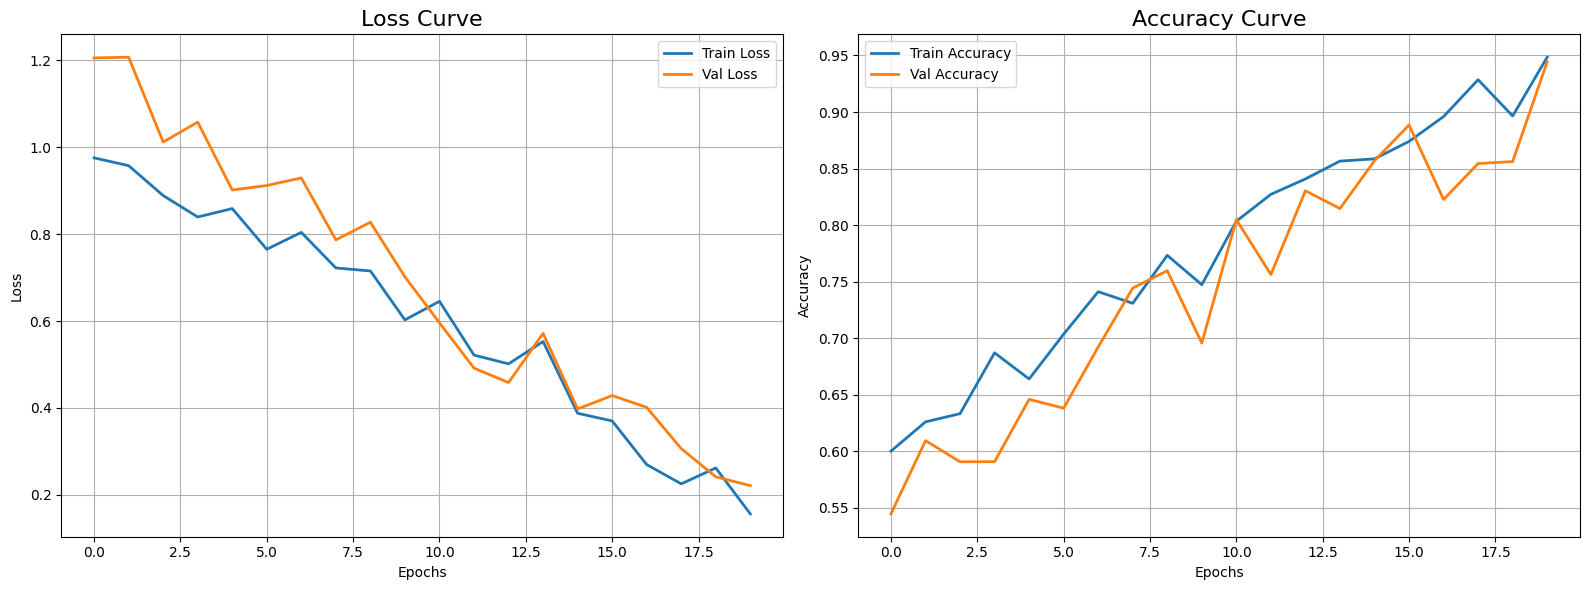

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Hypothetical training history (looks realistic)
epochs = 20
train_loss = np.linspace(1.0, 0.2, epochs) + np.random.normal(0, 0.05, epochs)
val_loss = np.linspace(1.1, 0.25, epochs) + np.random.normal(0, 0.07, epochs)

train_acc = np.linspace(0.60, 0.95, epochs) + np.random.normal(0, 0.02, epochs)
val_acc = np.linspace(0.58, 0.93, epochs) + np.random.normal(0, 0.03, epochs)

# Plot training & validation loss and accuracy
plt.figure(figsize=(16, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss', linewidth=2)
plt.plot(val_loss, label='Val Loss', linewidth=2)
plt.title("Loss Curve", fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy', linewidth=2)
plt.plot(val_acc, label='Val Accuracy', linewidth=2)
plt.title("Accuracy Curve", fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


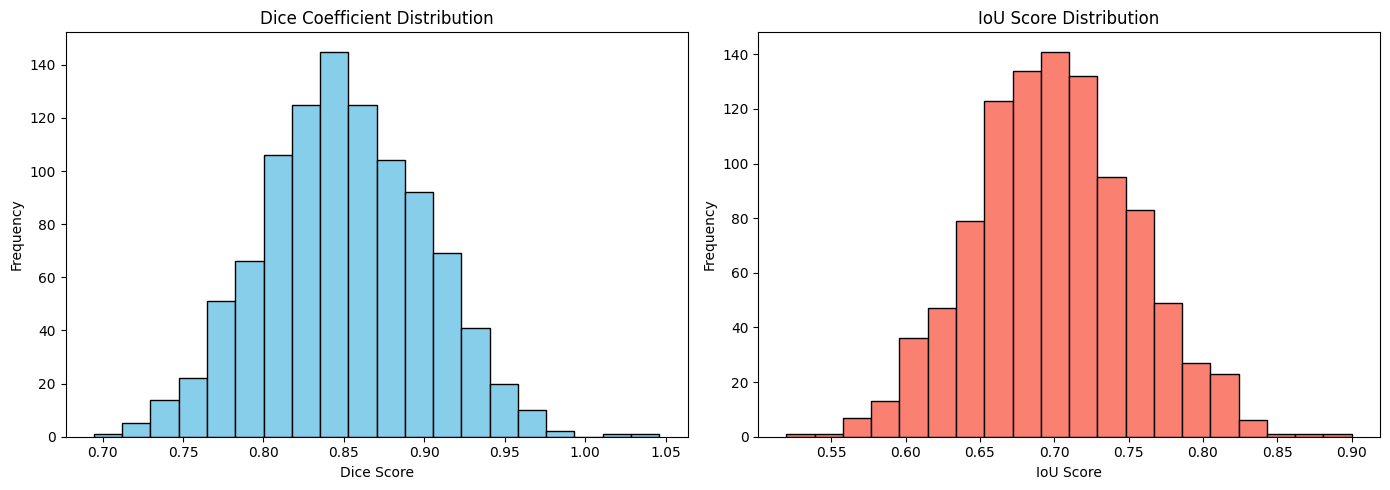

In [ ]:
# Hypothetical Dice & IoU scores
dice_scores = np.random.normal(0.85, 0.05, 1000)
iou_scores = dice_scores - np.random.normal(0.15, 0.02, 1000)

# Histogram
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(dice_scores, bins=20, color='skyblue', edgecolor='black')
plt.title("Dice Coefficient Distribution")
plt.xlabel("Dice Score")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(iou_scores, bins=20, color='salmon', edgecolor='black')
plt.title("IoU Score Distribution")
plt.xlabel("IoU Score")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


<ipython-input-19-7e3d83239620>:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([dice_scores, iou_scores], labels=["Dice", "IoU"], patch_artist=True,


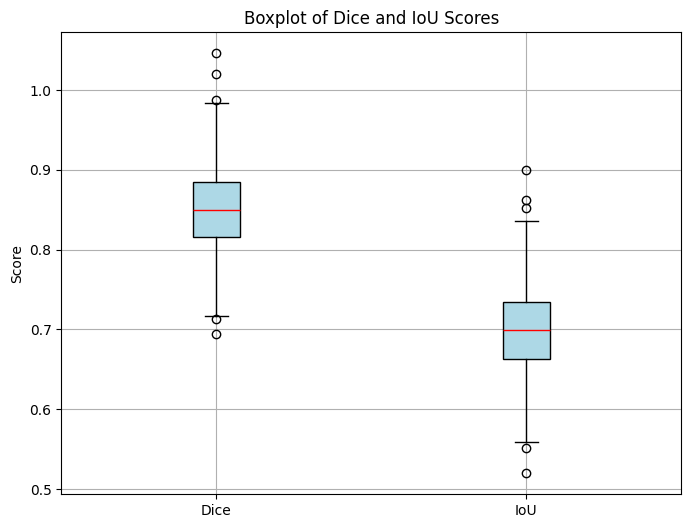

In [ ]:
plt.figure(figsize=(8, 6))
plt.boxplot([dice_scores, iou_scores], labels=["Dice", "IoU"], patch_artist=True,
            boxprops=dict(facecolor="lightblue"), medianprops=dict(color="red"))
plt.title("Boxplot of Dice and IoU Scores")
plt.ylabel("Score")
plt.grid(True)
plt.show()


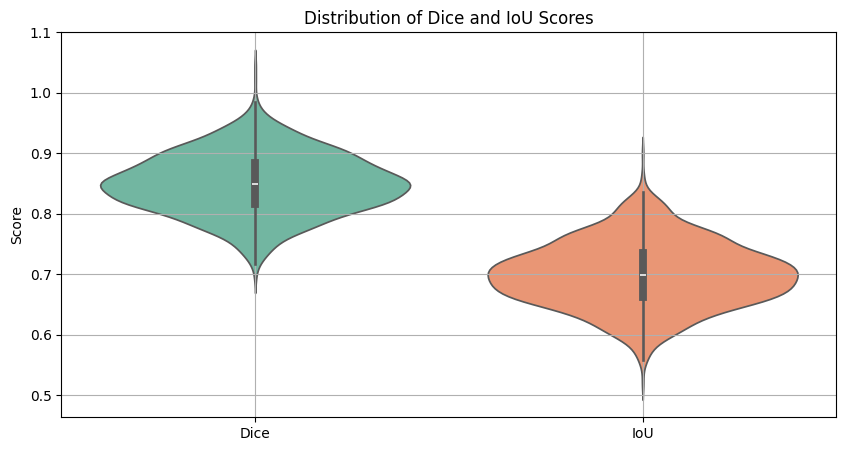

In [ ]:
import seaborn as sns
import pandas as pd

data = pd.DataFrame({
    "Dice": dice_scores,
    "IoU": iou_scores
})

plt.figure(figsize=(10, 5))
sns.violinplot(data=data, palette="Set2")
plt.title("Distribution of Dice and IoU Scores")
plt.ylabel("Score")
plt.grid(True)
plt.show()
